**CNN modelis.** Naudojama duomenų augmentacija, Sobel filtras, 3 fully-connected sluoksniai...

# Naudojamos bibliotekos #

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.ndimage import sobel
import pickle, gzip
from google.colab import files

# Sutvarkome failus ir duomenis

In [114]:
uploaded = files.upload() # Failų įkėlimas. flatland_train, flatland_test)

Saving flatland_test.data to flatland_test (2).data
Saving flatland_train.data to flatland_train (2).data


In [115]:
X, y = pickle.load(gzip.open("flatland_train.data", 'rb'))
X_eval, y_eval = pickle.load(gzip.open("flatland_test.data", 'rb'))
y[y!=0] -= 2 # laikysime, kad apskritimas=0, trikampis=1, kvadratas=2 ir t.t.
X = torch.tensor(X, dtype=torch.float32) / 255 # normalizuojame
X_eval = torch.tensor(X_eval, dtype=torch.float32) / 255 # normalizuojame
y = torch.tensor(y, dtype=torch.long)

# Naudosime GPU dėl greičio#

In [116]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Sobel filtras, kad išryškėtų briaunos ir kampai#

In [117]:
def apply_sobel(X):
    X_sobel = np.zeros_like(X)
    for i in range(X.shape[0]):
        img = X[i].numpy()
        sobel_x = sobel(img, axis=1)
        sobel_y = sobel(img, axis=0)
        sobel_img = np.hypot(sobel_x, sobel_y)
        X_sobel[i] = torch.tensor(sobel_img)
    return torch.tensor(X_sobel, dtype=torch.float32)

X = apply_sobel(X)
#Pritaikome filtrą ir eval duomenims
X_eval = apply_sobel(X_eval)

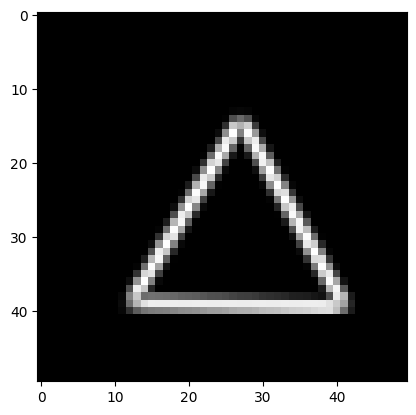

In [122]:
image = X[10]
image_np = image.cpu().numpy()

plt.imshow(image_np, cmap='gray')
plt.show()

# Augmentacija. Papildome duomenis, kad būtų po lygiai vienodų figūrų (išvengsime bias'o), pridedame apverstus image'us #

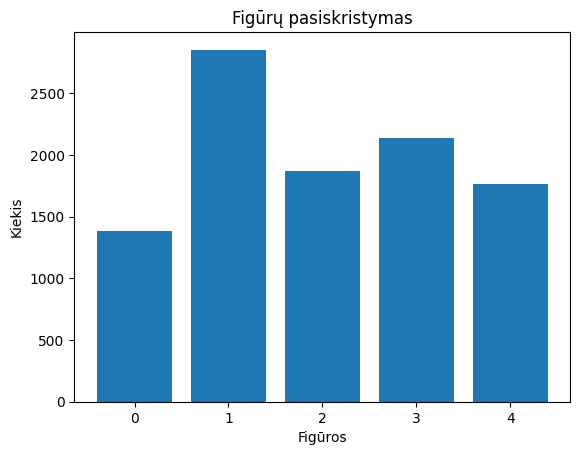

In [123]:
#figūrų pasiskirtymas
unique_labels, counts = np.unique(y.cpu().numpy(), return_counts=True)

plt.bar(unique_labels, counts)
plt.xlabel("Figūros")
plt.ylabel("Kiekis")
plt.title("Figūrų pasiskristymas")
plt.show()

In [124]:
# Papildome duomenis, kad figūrų skaičiai sutaptų, nebūtų bias'o.
unique_labels, counts = torch.unique(y, return_counts=True)

max_freq = counts.max().item()
for label, freq in zip(unique_labels, counts):
    num_to_augment = max_freq - freq.item()
    label_indices = torch.where(y == label)[0]
    label_images = X[label_indices]
    augmented_images = label_images.repeat_interleave(num_to_augment // freq.item() + 1, dim=0)
    augmented_images = augmented_images[:num_to_augment]
    X = torch.cat([X, augmented_images], dim=0)
    y = torch.cat([y, torch.tensor([label] * num_to_augment)], dim=0)
    y = torch.tensor(y, dtype=torch.long)

<ipython-input-124-54e088bc74ae>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


In [125]:
X = torch.cat((X, torch.flip(X, dims=[1]), torch.flip(torch.flip(X, dims=[1]),
        dims=[2])), dim=0) #augmentuojame diagonal ir horizontal flip'us

y = torch.cat((y, y, y), dim=0) #papildome label'ius

#train ir test split'as

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

#prijungiame grayscale chanel
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

train_dataset_ = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset_, batch_size=128, shuffle=True) #batchsize=128
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# CNN architektūra. Naudojame 3 fully connected sluoksnius, max pooling, drop'outas (be drop'outo ir su 2-3 epochomis modelis praktiškai turi tą patį tikslumą ~0.5% skirtumas)

In [128]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128*6*6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)

        self.dropout = nn.Dropout(p=0.65)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128*6*6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Inicijuojame modelį su criterion=CrossEntropy, optimizer=Adam.

In [129]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treniravimas ir testavimas #

In [130]:
epochs = 12 #TRENIRUOTI TIK SU GPU, NES CPU 1 EPOCHA UŽTRUNKA 5MIN

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_train / total_train * 100

    #Modelio įvertinimas su test data
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): #nereikia skaičiuoti gradientų
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    epoch_val_acc = 100 * correct_val / total_val

    print(f"Epoch: {epoch + 1}; Train Loss: {epoch_train_loss:.3f}")
    print(f"Train Acc: {epoch_train_acc:.2f}%")
print(f"Final Validation Acc: {epoch_val_acc:.2f}%")

Epoch: 1; Train Loss: 1.199
Train Acc: 44.89%
Epoch: 2; Train Loss: 0.640
Train Acc: 77.59%
Epoch: 3; Train Loss: 0.454
Train Acc: 87.03%
Epoch: 4; Train Loss: 0.376
Train Acc: 89.51%
Epoch: 5; Train Loss: 0.346
Train Acc: 90.91%
Epoch: 6; Train Loss: 0.310
Train Acc: 92.38%
Epoch: 7; Train Loss: 0.291
Train Acc: 92.98%
Epoch: 8; Train Loss: 0.292
Train Acc: 93.39%
Epoch: 9; Train Loss: 0.276
Train Acc: 93.81%
Epoch: 10; Train Loss: 0.258
Train Acc: 94.34%
Epoch: 11; Train Loss: 0.253
Train Acc: 94.51%
Epoch: 12; Train Loss: 0.251
Train Acc: 94.62%
Final Validation Acc: 98.08%


Keista, kad train acc. gana žemas, nors test duomenų split'e acc. siekia 98%.

# Modelio spėjimas ant X_eval duomenų#

In [131]:
eval_loader = torch.utils.data.DataLoader(X_eval.unsqueeze(1), batch_size=128, shuffle=False)

In [132]:
model.eval()
predictions = []

with torch.no_grad():
    for images in eval_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

predictions = np.array(predictions)
predictions[predictions != 0] += 2

#MISC#

In [110]:
#išsaugome spėjimą
with open('predictions.txt', 'w') as f:
    for nr in predictions:
        f.write(str(nr))
files.download('predictions.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [135]:
#išsaugome modelį
torch.save(model.state_dict(), "CNNmodel.pth")
files.download('CNNmodel.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>